In [1]:
import numpy as np
import pandas as pd
import random
import string

from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform, poisson

In [2]:
# city names
canada_cities = pd.read_csv('list-of-cities-in-canada-csv.csv',names=['city'])
canada_cities = list(canada_cities['city'])

#make of cars
car_make = [
    'honda',
    'toyota',
    'bmw',
    'mercedes',
    'ford',
    'gmc',
    'tesla',
    'chevy',
    'audi',
    'nissan',
    'acura',
]

model_dict = {
    'honda': ['civic', 'accord'],
    'toyota': ['camry', 'corrola'],
    'bmw': ['m3', 'i8', 'x5'],
    'mercedes': ['c', 's', 'g'],
    'ford': ['f150', 'focus', 'explorer'],
    'gmc': ['terrain','sierra','yukon'],
    'tesla': ['x', '3', 's'],
    'chevy': ['equinox', 'malibu'],
    'audi': ['r8','e-tron'],
    'nissan':['mirano','micro'],
    'acura':['rsx', 'mdx']
}


In [3]:
parameters = {'age':  sp_randint(18, 85),
              'city': canada_cities,
              'year': sp_randint(1998, 2020),
              'make': car_make,
              'dist': sp_randint(1200, 25000),
              'gender': ['m','f'],
              }

# other columns
    # new_used
    # model

p_list = list(ParameterSampler(parameters, n_iter=5000,))

In [4]:
df = pd.DataFrame(p_list)
df

,age,city,dist,gender,make,year
0,65,Vaughan,15487,f,bmw,2014
1,27,New Westminster,3266,f,honda,2013
2,70,Longueuil,17958,m,bmw,2006
3,60,Terrebonne,16729,f,toyota,2008
4,65,Chatham-Kent,6883,m,ford,1998
...,...,...,...,...,...,...
4995,76,Edmonton,20490,f,toyota,2008
4996,64,Richmond Hill,22254,m,ford,2017
4997,56,Quebec City,12152,f,gmc,1999
4998,44,Burnaby,16349,f,honda,2003


In [5]:
def select_model_and_age(df, model_dict):
    model_list = []
    age_list = []
    
    for i in df.itertuples():
        if i.make in list(model_dict.keys()):
            model_ind = random.choice(model_dict[i.make])
            model_list.append(model_ind)
        else:
            model_list.append('other')
            
        if i.year > 2018:
            age_list.append('new')
        else:
            age_list.append('used')
            
        
    
        
            
    df['model'] = model_list
    df['new_used'] = age_list
    return df

In [6]:
df = select_model_and_age(df, model_dict)
df.head()

,age,city,dist,gender,make,year,model,new_used
0,65,Vaughan,15487,f,bmw,2014,x5,used
1,27,New Westminster,3266,f,honda,2013,accord,used
2,70,Longueuil,17958,m,bmw,2006,x5,used
3,60,Terrebonne,16729,f,toyota,2008,camry,used
4,65,Chatham-Kent,6883,m,ford,1998,explorer,used


In [7]:
def insurance_price(df, base_rate, weights):
    weight_age = weights['weight_age']
    weight_city = weights['weight_city']
    weight_year = weights['weight_year']
    weight_make = weights['weight_make']
    weight_dist = weights['weight_dist']
    weight_gender = weights['weight_gender']
    rate_age = weights['rate_age']
    rate_make = weights['rate_make']
    rate_city = weights['rate_city']
    rate_year = weights['rate_year']
    rate_dist = weights['rate_dist']
    rate_gender = weights['rate_gender']
    
    # cost = base_rate + (weight_age * rate_age * age / 100) + weight_city * rate_city * category_cost+
    # weight_make * rate_make * category_cost + (weight_dist * dist * rate_dist)/1000 + 
    # weight_gender * rate_gender
    l = []
    for i in df.itertuples():
        # age buckets
        if i.age < 30:
            age_category_cost = 100
        elif i.age >=30 < 65:
            age_category_cost = 20
        elif i.age >=65 < 75:
            age_category_cost = 40
        else:
            age_category_cost = 120
        
        # city buckets
        city_index = string.ascii_lowercase.index(i.city[0].lower())
        if city_index < 10:
            city_category_cost = 10
        elif city_index >=10 < 17:
            city_category_cost = 50
        else:
            city_category_cost = 80
            
        
        # make buckets
        if i.make in ['honda', 'toyota','gmc','nissan','ford','chevy']:
            make_category_cost = 50
        elif i.make in ['acura', 'tesla']:
            make_category_cost = 90
        elif i.make in ['mercedes','bmw', 'audi']:
            make_category_cost = 140
        else:
            make_category_cost = 60
            
        # gender buckets
        if i.gender == 'm':
            gender_category_cost = 100
        else:
            gender_category_cost = 50
        
        # distance buckets
        if i.dist <3000:
            dist_category_cost = 50
        elif i.dist >=3000 < 8000:
            dist_category_cost = 100
        else:
            dist_category_cost = 160

            
        # calculation for making the cost
        cost_total = (base_rate + (weight_age * age_category_cost) ** rate_age  + (weight_city * city_category_cost) ** rate_city + (weight_make * make_category_cost) ** rate_make + (weight_dist * dist_category_cost) ** rate_dist + (weight_gender * gender_category_cost) ** rate_gender)/4
                
        l.append(cost_total/12.0)
    df2 = df.copy()
    df2['quote'] = l
    return df2

In [8]:
weight_params = {
    "weight_age": uniform(loc=0.8,scale=3),
    "weight_city": uniform(loc=0.5,scale=1.5),
    "weight_year": uniform(loc=0.4,scale=2),
    "weight_make": uniform(loc=0.9,scale=2),
    "weight_dist": uniform(loc=0.9,scale=1.5),
    "weight_gender": uniform(loc=0.9,scale=1.5),
    "rate_age": uniform(loc=0.9,scale=1.1),
    "rate_city": uniform(loc=0.9,scale=1.1),
    "rate_make": uniform(loc=0.9,scale=1.1),
    "rate_year": uniform(loc=0.9,scale=1.1),
    "rate_dist": uniform(loc=0.9,scale=1.1),
    "rate_gender": uniform(loc=0.9,scale=1.1),
}

weight_params_list = list(ParameterSampler(weight_params, n_iter=25,random_state=16))
weight_params_list[0:2]

[{'rate_age': 1.145620187068893,
  'rate_city': 1.4754796755407438,
  'rate_dist': 1.5057716022392993,
  'rate_gender': 0.950162145146087,
  'rate_make': 1.29680171888255,
  'rate_year': 1.1453890358604177,
  'weight_age': 2.8661784854640695,
  'weight_city': 0.7455971375013488,
  'weight_dist': 1.0054873002082505,
  'weight_gender': 2.311516290368754,
  'weight_make': 2.0273627604696505,
  'weight_year': 0.5559846787799742},
 {'rate_age': 1.694904562237324,
  'rate_city': 1.0742973908754831,
  'rate_dist': 1.1753094374184259,
  'rate_gender': 1.2228359817124173,
  'rate_make': 1.6662717856294544,
  'rate_year': 1.410690496844167,
  'weight_age': 1.4451864311430187,
  'weight_city': 1.1702393931194863,
  'weight_dist': 1.0813181273084354,
  'weight_gender': 2.2765305116170875,
  'weight_make': 2.032892657438391,
  'weight_year': 1.3440386314838544}]

In [9]:
df2 = insurance_price(df, 100, weight_params_list[2])
df2

,age,city,dist,gender,make,year,model,new_used,quote
0,65,Vaughan,15487,f,bmw,2014,x5,used,398.042836
1,27,New Westminster,3266,f,honda,2013,accord,used,139.445537
2,70,Longueuil,17958,m,bmw,2006,x5,used,433.598257
3,60,Terrebonne,16729,f,toyota,2008,camry,used,133.731255
4,65,Chatham-Kent,6883,m,ford,1998,explorer,used,168.318406
...,...,...,...,...,...,...,...,...,...
4995,76,Edmonton,20490,f,toyota,2008,camry,used,132.762985
4996,64,Richmond Hill,22254,m,ford,2017,explorer,used,169.286676
4997,56,Quebec City,12152,f,gmc,1999,sierra,used,133.731255
4998,44,Burnaby,16349,f,honda,2003,accord,used,132.762985


In [16]:
l = []
index_counter = 0
for i in weight_params_list:
    p_list = list(ParameterSampler(parameters, n_iter=20000,))
    df = pd.DataFrame(p_list)
    df = select_model_and_age(df, model_dict)
    df2 = insurance_price(df, 100, i)
    a = df2['quote'].to_numpy()
    name = 'company_{}.csv'.format(index_counter)
    df2.to_csv(name, index=False)
    l.append(a)
    index_counter += 1
    
l = np.array(l)
df3 = pd.DataFrame(l.T)

KeyboardInterrupt: 

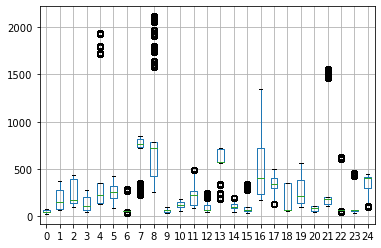

In [14]:
boxplot = df3.boxplot()

In [15]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,65.434111,75.666693,397.074566,222.979015,140.825912,321.790178,48.316449,819.158314,410.040033,89.599233,...,94.515088,236.382290,449.773993,65.052714,282.601189,51.266252,140.751103,64.235799,45.632688,295.413493
1,40.366004,282.749458,227.778070,42.328290,140.825912,358.322171,58.337741,733.730332,431.022626,40.263365,...,80.855027,236.382290,449.773993,68.318271,137.933850,100.094498,205.092982,65.064065,62.790162,435.972179
2,42.137233,376.139196,175.000958,94.425332,220.526071,391.203311,50.984946,733.730332,410.040033,40.098804,...,93.534647,1340.639210,340.883262,59.169126,159.918380,39.012495,140.751103,618.216661,61.772078,435.972179
3,75.120556,374.782562,133.731255,201.532343,140.825912,124.652945,50.984946,737.269358,421.946006,52.138131,...,52.627740,231.528967,378.569960,163.166405,282.601189,51.266252,122.448236,62.517544,448.953981,286.448190
4,65.434111,67.937182,433.598257,67.995787,142.092189,190.216720,274.336810,737.269358,720.832348,36.338945,...,96.196944,236.382290,449.773993,158.366175,115.555535,48.777592,171.384638,59.790122,448.003344,433.205724
